# KMeans clustering for Football Analysis

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import missingno as msno 
from statsbombpy import sb
from mplsoccer.pitch import Pitch
from sklearn.cluster import KMeans
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Belgium v Italy EURO 2020

In [4]:
matches = sb.matches(55,43)

credentials were not supplied. open data access only


In [5]:
belgium = matches[(matches['home_team'] == 'Belgium') | (matches['away_team'] == 'Belgium')]

In [6]:
belgium

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,data_version,shot_fidelity_version,xy_fidelity_version
2,3795107,2021-07-02,21:00:00.000,Europe - UEFA Euro,2020,Belgium,Italy,1,2,available,available,2022-02-01T17:20:34.319496,2021-09-23T00:02:51.495862,5,Quarter-finals,Allianz Arena,Slavko Vinčić,1.1.0,2,2
8,3794687,2021-06-27,21:00:00.000,Europe - UEFA Euro,2020,Belgium,Portugal,1,0,available,available,2021-07-05T13:37:21.633,2021-09-22T16:40:48.020474,4,Round of 16,Estadio de La Cartuja,Felix Brych,1.1.0,2,2
13,3788768,2021-06-21,21:00:00.000,Europe - UEFA Euro,2020,Finland,Belgium,0,2,available,available,2021-06-22T13:47:34.925,2021-09-22T16:40:14.297313,3,Group Stage,Saint-Petersburg Stadium,Felix Brych,1.1.0,2,2
18,3788757,2021-06-17,18:00:00.000,Europe - UEFA Euro,2020,Denmark,Belgium,1,2,available,available,2021-07-24T16:17:22.251,2021-09-22T16:39:19.238605,2,Group Stage,Parken,Björn Kuipers,1.1.0,2,2
49,3788743,2021-06-12,21:00:00.000,Europe - UEFA Euro,2020,Belgium,Russia,3,0,available,available,2021-06-13T13:10:11.602,2021-09-22T16:38:15.368959,1,Group Stage,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz,1.1.0,2,2


In [7]:
event = sb.events(3795107)

credentials were not supplied. open data access only


## Get the passes

In [8]:
df = event[['team', 'type', 'location', 'pass_end_location']]

In [9]:
be = df[(df['team'] == 'Belgium') & (df['type'] == 'Pass')]

In [10]:
#function to get coordinates (x,y)
def get_passes(df):
    df['x'] = [i[0] for i in df['location'].values]
    df['y'] = [i[1] for i in df['location'].values]
    df['endX'] = [i[0] for i in df['pass_end_location'].values]
    df['endY'] = [i[1] for i in df['pass_end_location'].values]
    df = df.drop(['location', 'pass_end_location'], axis =1)
    return df

In [11]:
be = get_passes(be)

In [11]:
be

,team,type,x,y,endX,endY
6,Belgium,Pass,60.0,40.0,54.2,36.3
7,Belgium,Pass,51.4,33.7,34.1,17.5
8,Belgium,Pass,33.0,14.7,41.1,1.6
9,Belgium,Pass,37.1,2.3,5.4,30.9
10,Belgium,Pass,7.5,32.2,9.5,51.3
...,...,...,...,...,...,...
1029,Belgium,Pass,97.8,22.0,95.6,52.9
1030,Belgium,Pass,96.6,55.2,115.5,60.7
1031,Belgium,Pass,115.8,60.7,113.5,48.2
1032,Belgium,Pass,120.0,80.0,113.8,51.4


## KMeans Clusters

In [16]:
#create variable X and fit it
#from sklearn.cluster import KMeans
X = np.array(be[['x','y','endX', 'endY']])
kmeans = KMeans(n_clusters = 10, random_state=42)
kmeans.fit(X)
be['cluster'] = kmeans.predict(X)

__WSS__ : The sum distance within the centroids. Since the K-means algorithm's goal is to keep the size of each cluster as small as possible, the small wss indicates that every data point is close to its nearest centroids, or say the model has returned good results.

In [20]:
# elbow method
K = range(1,10+1)
wss= []
for k in K:
    array = np.array(be[['x', 'y', 'endX', 'endY']])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(array)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
mycenters = pd.DataFrame({'Clusters':K, 'WSS':wss})
mycenters

,Clusters,WSS
0,1,1.504684e+06
1,2,9.098918e+05
2,3,6.742609e+05
3,4,5.125319e+05
4,5,4.320295e+05
5,6,3.774757e+05
6,7,3.451918e+05
7,8,3.190188e+05
8,9,2.921541e+05
9,10,2.741735e+05


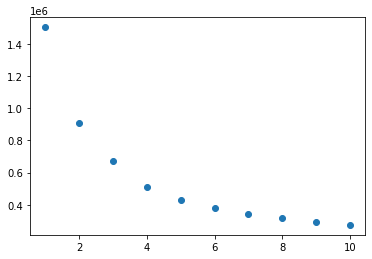

In [21]:
plt.scatter(x=mycenters['Clusters'], y=mycenters['WSS'])

In [12]:
be.cluster.value_counts()

5    58
6    57
1    56
2    56
3    51
4    47
9    44
8    39
7    38
0    36
Name: cluster, dtype: int64

## Clustered Passes Viz

In [14]:
### function to check available colors

# import matplotlib
# i = 0 
# for cname, hex in matplotlib.colors.cnames.items():
#     print(cname,hex)
#     i += 1
#     if i >100:
#         break

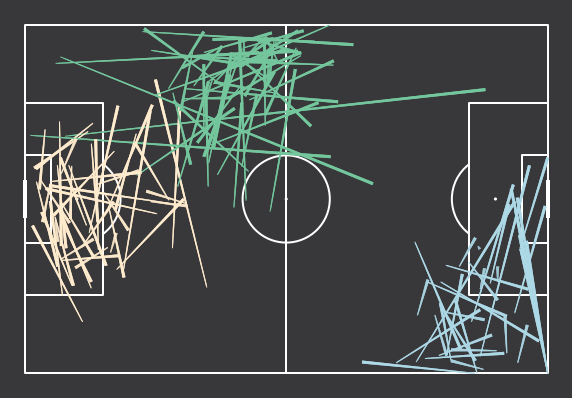

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor('#38383b')
ax.patch.set_facecolor('#38383b')

pitch = Pitch(orientation='horizontal', pitch_color = '#38383b', line_color = 'white', figsize = (10,10),
             constrained_layout=False, tight_layout=True, view='full')

pitch.draw(ax=ax)

for row in range(len(be['cluster'])):
    
    if be['cluster'].values[row] == 5: #the location of passes from where Belgium made most of their passes
        pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
                yend=be['endY'].values[row],color='#74c69d', lw=3, zorder=2, comet=True, ax=ax)
        
    if be['cluster'].values[row] == 0: #the location of passes from where Belgium made least of their passes
        pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
                yend=be['endY'].values[row],color='#add8e6', lw=3, zorder=2, comet=True, ax=ax)
        
    if be['cluster'].values[row] == 9: #the location of passes from where Belgium made the second least of their passes
        pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
            yend=be['endY'].values[row],color='#FFEBCD', lw=3, zorder=2, comet=True, ax=ax)
        
#     if be['cluster'].values[row] == 7: #the location of passes from where Belgium made the second most of their passes
#         pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
#             yend=be['endY'].values[row],color='#A52A2A', lw=3, zorder=2, comet=True, ax=ax)
        
